# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [44]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [45]:
# Check columns in df
print("Columns in df:")
print(df.columns)

# Check columns in df_content
print("\nColumns in df_content:")
print(df_content.columns)

Columns in df:
Index(['article_id', 'title', 'email'], dtype='object')

Columns in df_content:
Index(['doc_body', 'doc_description', 'doc_full_name', 'doc_status',
       'article_id'],
      dtype='object')


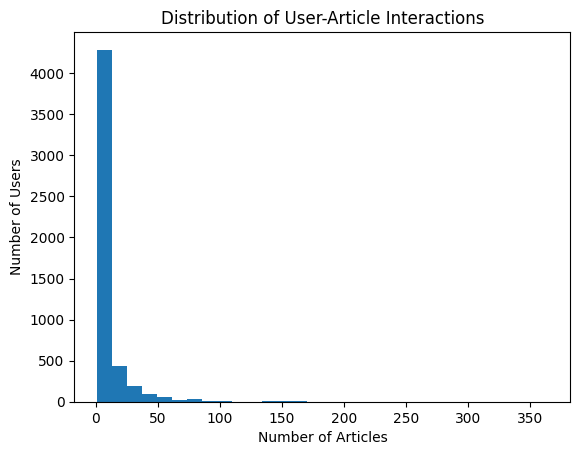

In [46]:
# Assuming email as unique user identifier
user_article_counts = df['email'].value_counts()
user_article_counts.plot(kind='hist', bins=30)
plt.xlabel('Number of Articles')
plt.ylabel('Number of Users')
plt.title('Distribution of User-Article Interactions')
plt.show()


In [47]:
# Group by user_id and count the number of article interactions per user
interactions_per_user = df.groupby('email')['article_id'].count()

# Calculate the median value
median_val = interactions_per_user.median()
print(f"50% of individuals interact with {median_val} number of articles or fewer.")

# Calculate the maximum number of interactions by any user
max_views_by_user = interactions_per_user.max()
print(f"The maximum number of user-article interactions by any 1 user is {max_views_by_user}.")

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [48]:
# Find and explore duplicate articles
# Assuming 'article_id' is the unique identifier for articles

# Step 1 & 2: Identify and mark all duplicates
duplicates = df_content.duplicated(subset='article_id', keep=False)

# Step 3: Filter the DataFrame to only include duplicates
duplicate_articles = df_content[duplicates]

# Step 4: Display the count of duplicate articles
print(f"Number of duplicate articles: {duplicate_articles.shape[0]}")

# Step 5: Explore duplicates (showing the first few)
print("\nDetails of duplicate articles:")
print(duplicate_articles.sort_values(by='article_id').head())

Number of duplicate articles: 10

Details of duplicate articles:
                                              doc_body  \
50   Follow Sign in / Sign up Home About Insight Da...   
365  Follow Sign in / Sign up Home About Insight Da...   
221  * United States\r\n\r\nIBM® * Site map\r\n\r\n...   
692  Homepage Follow Sign in / Sign up Homepage * H...   
232  Homepage Follow Sign in Get started Homepage *...   

                                       doc_description  \
50                        Community Detection at Scale   
365  During the seven-week Insight Data Engineering...   
221  When used to make sense of huge amounts of con...   
692  One of the earliest documented catalogs was co...   
232  If you are like most data scientists, you are ...   

                                         doc_full_name doc_status  article_id  
50                        Graph-based machine learning       Live          50  
365                       Graph-based machine learning       Live          50

In [49]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset='article_id', keep='first')

# check if all duplicated rows have been removed
df_content.article_id.duplicated().sum()

np.int64(0)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [50]:

# a. The number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique()

# b. The number of unique articles on the IBM platform
total_articles = df_content['article_id'].nunique()

# c. The number of unique users
unique_users = df['email'].nunique(dropna=True)

# d. The number of user-article interactions
user_article_interactions = df.shape[0]

# Print the results
print(f"a. Number of unique articles that have at least one interaction: {unique_articles}")
print(f"b. Number of unique articles on the IBM platform: {total_articles}")
print(f"c. Number of unique users: {unique_users}")
print(f"d. Number of user-article interactions: {user_article_interactions}")

a. Number of unique articles that have at least one interaction: 714
b. Number of unique articles on the IBM platform: 1051
c. Number of unique users: 5148
d. Number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [51]:
# Step 1 & 2: Group by 'article_id' and count the occurrences
article_views = df.groupby('article_id').size()

# Step 3: Find the article_id with the maximum views
most_viewed_article_id = str(article_views.idxmax())

# Step 4: Retrieve the number of views for this article
max_views = article_views.max()

# Print the results
print(f"Most viewed article_id: {most_viewed_article_id}")
print(f"Number of views: {max_views}")

Most viewed article_id: 1429.0
Number of views: 937


In [52]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [53]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [54]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    '''
    # Group by article title and count the interactions
    article_counts = df.groupby('title').size().reset_index(name='count')
    
    # Sort the articles by the number of interactions in descending order
    sorted_articles = article_counts.sort_values('count', ascending=False)
    
    # Get the top 'n' article titles
    top_articles = sorted_articles['title'].head(n).tolist()
    
    return top_articles# Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    top_articles = df['article_id'].value_counts().index.tolist()[:n]
    top_articles = [str(i) for i in top_articles]

    return top_articles # Return the top article ids

In [55]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [56]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [57]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    user_item = df.groupby(['user_id', 'article_id'])['article_id'].count().unstack()
    user_item = user_item.fillna(0)
    user_item[user_item > 1] = 1

    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [59]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    '''
    # Compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.loc[user_id])
    
    # Sort by similarity
    similarity = similarity.sort_values(ascending=False)
    
    # Create list of just the ids
    most_similar_users = similarity.index.tolist()
   
    # Remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users

In [60]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 3782, 23, 203, 4459, 131, 3870, 4201, 46, 395]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [61]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Initialize an empty list to hold the article names
    article_names = []
    
    # Iterate over the list of article_ids
    for article_id in article_ids:
        # Find the article name(s) corresponding to the current article_id
        # Use drop_duplicates() to ensure each name is only returned once
        names = df[df['article_id'].astype(str) == str(article_id)]['title'].drop_duplicates().tolist()
        
        # Extend the article_names list with the names found
        article_names.extend(names)
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    df_content - (pandas dataframe) dataframe with article details, including doc_full_name
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Find the articles interacted with by the user
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype('str')
    
    article_names = []

    for idx in article_ids:
        article_names.append(df[df['article_id']==float(idx)].max()['title']) # need to use df instead of df_content as it only has 1051 rows
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    seen_article_ids, _ = get_user_articles(user_id)  # Assuming this function returns article ids and names
    similar_users = find_similar_users(user_id)  # Assuming this function returns a list of user ids sorted by similarity
    
    for similar_user in similar_users:
        if len(recs) >= m:
            break
        similar_user_article_ids, _ = get_user_articles(similar_user)
        new_recs = list(set(similar_user_article_ids) - set(seen_article_ids))
        recs.extend(new_recs[:m - len(recs)])
    
    return recs[:m]  # Ensure we don't return more than m recommendations  

In [62]:
# Check Results
get_article_names(user_user_recs(1, 20)) # Return 10 recommendations for user 1

['recent trends in recommender systems',
 'how smart catalogs can turn the big data flood into an ocean of opportunity',
 'spark-based machine learning tools for capturing word meanings',
 'generalization in deep learning',
 'ml algorithm != learning machine',
 'data visualization playbook: telling the data story',
 'times world university ranking analysis',
 'aspiring data scientists! start to learn statistics with these 6 books!',
 'using bigdl in dsx for deep learning on spark',
 'machine learning for the enterprise',
 'this week in data science (april 18, 2017)',
 'visualize data with the matplotlib library',
 'get started with streams designer by following this roadmap',
 'optimizing a marketing campaign: moving from predictions to actions',
 'graph-based machine learning',
 'model bike sharing data with spss',
 'overlapping co-cluster recommendation algorithm (ocular)',
 'a visual explanation of the back propagation algorithm for neural networks',
 'shaping data with ibm data ref

In [63]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [64]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    similarity = np.dot(user_item.iloc[user_id-1],np.transpose(user_item))
    interactions = df.groupby('user_id').count().sort_values('title',ascending=False)
    neighbors_df=pd.DataFrame(columns=['neighbor_id','similarity','num_interactions'])
    neighbors_df['neighbor_id'] = user_item.index
    neighbors_df.index = neighbors_df.neighbor_id
    neighbors_df['similarity'] = similarity
     # Ensure the length matches before assignment
    if len(interactions) == len(df):
        df['num_interactions'] = interactions
    #neighbors_df['num_interactions'] = interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity','num_interactions'],ascending=False)
    neighbors_df = neighbors_df[neighbors_df.neighbor_id != user_id]
    
    
    return neighbors_df # Return the dataframe specified in the doc_string

def get_sorted_neighbor_articles(user_id, top_article_ids):
    """
    INPUT:
    user_id - (int) a user id
    top_article_ids - a list of article ids sorted by the number of interactions 
                    in descending order

    Output:
    recs - (list) a list of articles for the user sorted by articles' overall number of interactions
    rec_names - (list) a list of recommendations for the user by article title
    """

    final_article_ids, _ = get_user_articles(user_id)

    article_sort_id = []

    for article_id in final_article_ids:
        article_sort_id.append(top_article_ids.index(article_id))

    final_user_top_articles = sorted(zip(final_article_ids, article_sort_id), key=lambda x: x[1])
    final_user_top_articles = [x[0] for x in final_user_top_articles]

    # append required number of articles to the recommendation list
    recs = final_user_top_articles
    
    return recs

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here   
    
    top_article_ids = get_top_article_ids(int(df['article_id'].max()))
    
    recs = get_sorted_neighbor_articles(user_id, top_article_ids)
    recs = list(set(recs[:m]))
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names
    

In [65]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['844.0', '1320.0', '232.0']

The top 10 recommendations for user 20 are the following article names:
['use the cloudant-spark connector in python notebook', 'housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [66]:

### Tests with a dictionary of results

# Assuming df is the dataframe containing user interactions
user1_most_sim = get_top_sorted_users(1, df).iloc[0].neighbor_id # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131, df).iloc[9].neighbor_id # Find the 10th most similar user to user 131

print(user1_most_sim)
print(user131_10th_sim)

3933
242


In [67]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**
If given a new user, it would make sense to use Rank Based Recommendations and the get_top_articles function to make recommendations. We would just recommend the most popular articles since we do not have any information about the user or their interactions so cannot tell which other users they are most similar to. Once we have more information about the user we could a blended approach of 3 types of recommendation techniques; Rank, Content, and Collaborative.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [68]:
new_user_recs = get_top_article_ids(10) # Find the 10 most recommended articles for a new user
print(set(new_user_recs))

{'1330.0', '1431.0', '1170.0', '1429.0', '1314.0', '1162.0', '1427.0', '1304.0', '1293.0', '1364.0'}


In [69]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."
# ['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']
print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

def make_content_recs(user_id, content_data=df_content, user_preferences='', top_n=10):
    '''
    INPUT:
    user_id - (int) ID of the user for whom recommendations are to be made
    content_data - (DataFrame) a dataframe containing content information with columns for content IDs and text
    user_preferences - (str) a string representing the user's preferred content or keywords
    top_n - (int) the number of recommendations to return
    
    OUTPUT:
    recommendations - (list) a list of content IDs representing the top_n recommendations
    
    Description:
    Implements a content-based recommendation system by comparing user preferences to content descriptions.
    '''
   
    # Preprocess the content data
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(content_data['doc_full_name'])  # Use the text_column parameter here
    
    # Convert user preferences to a vector
    user_pref_vector = tfidf.transform([user_preferences])
    
    # Compute cosine similarity between user preferences and content
    cosine_sim = cosine_similarity(user_pref_vector, tfidf_matrix)
    
    # Get similarity scores for all content and sort them
    sim_scores = list(enumerate(cosine_sim[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Select the top_n content IDs
    content_indices = [i[0] for i in sim_scores[:top_n]]
    recommendations = content_data['article_id'].iloc[content_indices].tolist()
    
    return recommendations

print(make_content_recs(user_id='1427.0'))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**
The content-based recommendation system implemented in the provided code works by following these steps:

Preprocessing Content Data: It uses the TfidfVectorizer from sklearn to convert the text data from the content_data DataFrame into a TF-IDF matrix. This matrix represents the importance of words in the content relative to the corpus of all content, effectively turning the text into a numerical format that can be analyzed.

User Preferences to Vector: The user's preferences, represented as a string, are also transformed into a TF-IDF vector using the same vectorizer. This ensures that the user's preferences and the content are represented in the same feature space.

Cosine Similarity Calculation: The cosine similarity between the user's preference vector and each content's vector in the TF-IDF matrix is computed. This similarity score represents how closely the content matches the user's preferences based on the content's text.

Ranking and Recommendations: The content is then ranked based on these similarity scores, and the top n content items are selected as recommendations. The top_n parameter allows the number of recommendations to be adjusted.

Output: The function returns a list of content IDs that best match the user's preferences, serving as the recommendations.

Possible Improvements:

Performance Optimization: For large datasets, the computation of the TF-IDF matrix and cosine similarity can be resource-intensive. Implementing a more efficient way to store and compute these, possibly by using sparse matrices or parallel processing, could improve performance.
Dynamic Updating: As new content is added, the TF-IDF matrix needs to be updated. Implementing an efficient way to update this matrix without recomputing it from scratch could enhance the system's responsiveness.
Personalization: Incorporating more personalized features, such as past user interactions with content (clicks, likes, time spent), could improve the relevance of the recommendations.
Diversity and Novelty: Introducing mechanisms to ensure diversity and novelty in the recommendations could enhance user satisfaction by avoiding the "filter bubble" effect.
Novelty:

The approach is straightforward and effective, leveraging TF-IDF and cosine similarity, which are well-established techniques in information retrieval. While the basic methodology is not novel, the application and the specific combination of techniques used for content-based recommendation can be tailored to the dataset and domain, offering a customized recommendation experience.


`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [71]:
# make recommendations for a brand new user
new_user_recs = get_top_article_ids(10)
print(new_user_recs)

# make a recommendations for a user who only has interacted with article id '1427.0'
# Assuming 'article_body' is the correct column name for the textual content
user_article_recs = make_content_recs(user_id='1427')
print(user_article_recs)



['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [72]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [73]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [74]:
u, s, vt = np.linalg.svd(user_item_matrix)


**Provide your response here.**
Performing SVD with NumPy:

Import NumPy: Ensure NumPy is imported to use its SVD functionality.

Prepare the User-Item Matrix: The user-item matrix should be ready for decomposition. This matrix typically has users as rows and items (such as articles or products) as columns. The values represent some form of interaction, like viewing an article or purchasing a product.

Apply SVD: Use NumPy's linalg.svd to decompose the matrix.


Explanation of Differences from the Lesson:

Data Nature: The lesson might have used a dense matrix with explicit ratings, while in this scenario, the matrix could be binary (1 for interaction, 0 for no interaction) or sparse (many zeros), affecting how SVD is applied and interpreted.

Handling Sparsity: Traditional SVD as implemented in NumPy does not handle missing values, which are common in real-world user-item matrices. If the matrix is sparse but does not contain explicit NaN values representing missing data, NumPy's SVD can still be applied directly. This contrasts with some lessons that might use matrix factorization techniques designed to handle missing data explicitly, like FunkSVD.

Dimensionality Reduction: The lesson might have emphasized reducing the dimensionality of the data to capture the most important latent factors. While this is also relevant here, the approach to selecting the number of components (latent factors) might vary based on the dataset's characteristics and the goal of the recommendation system.

Application Context: The specific application (e.g., recommending articles in IBM Watson) might require adjustments to the standard SVD approach, such as how to interpret and use the decomposed matrices for making recommendations.
Why Use SVD in This Context:

Efficiency and Simplicity: SVD is a powerful tool for identifying latent structures in the data, making it suitable for recommendation systems where understanding user preferences and item characteristics is crucial.
Predictive Power: By decomposing the user-item matrix, SVD allows for predictions of user preferences for items they haven't interacted with, based on the latent features extracted.

Adaptability: While different from the lesson, the principles of SVD remain applicable across various datasets and recommendation system designs, making it a versatile tool for these purposes.
This approach leverages the strengths of SVD for recommendation systems, adapting to the specific characteristics and requirements of the dataset and application context.




`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

/home/subhopam/.pyenv/versions/3.12.4/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


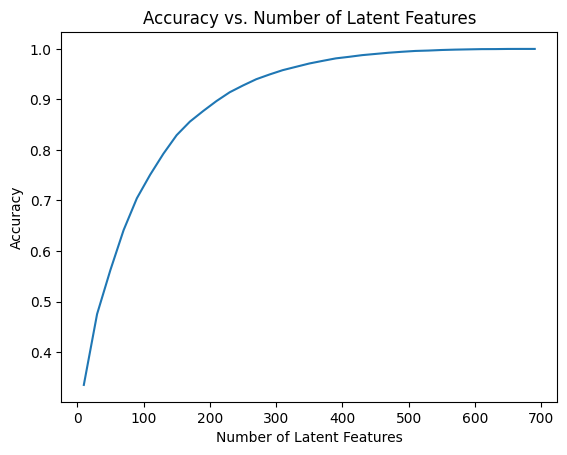

In [75]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [76]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
    
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [77]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [78]:
u_train, s_train, vt_train = np.linalg.svd(user_item_train)


In [79]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
train_idx = np.array(user_item_train.index)
train_arts = np.array(user_item_train.columns)
test_user = np.intersect1d(test_idx,train_idx)
test_articles = np.intersect1d(test_arts,train_arts)
test_user_idx = np.where(np.in1d(train_idx, test_user))[0]
test_art_idx = np.where(np.in1d(train_arts, test_articles))[0]
test_indexes = np.where(np.in1d(test_idx, test_user))[0]
user_item_test = user_item_test.iloc[test_indexes,:]

/tmp/ipykernel_12135/877208647.py:7: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  test_user_idx = np.where(np.in1d(train_idx, test_user))[0]
/tmp/ipykernel_12135/877208647.py:8: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  test_art_idx = np.where(np.in1d(train_arts, test_articles))[0]
/tmp/ipykernel_12135/877208647.py:9: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  test_indexes = np.where(np.in1d(test_idx, test_user))[0]


/home/subhopam/.pyenv/versions/3.12.4/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


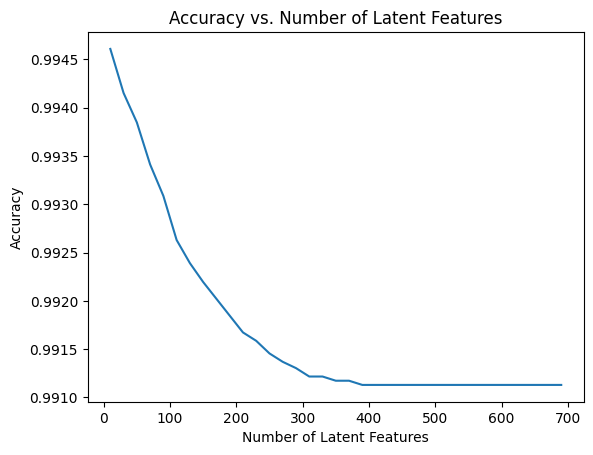

In [80]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    u_test, vt_test = u_new[test_user_idx,:], vt_new[:,test_art_idx]
    
    # take dot product
    user_item_test_est = np.around(np.dot(np.dot(u_test, s_new), vt_test))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test, user_item_test_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

To evaluate if the recommendations made by the recommendation systems are an improvement over the current method users find articles, consider the following approach:

***A/B Testing:***

 Implement an A/B test where Group A continues to find articles using the current method, while Group B uses the new recommendation system. Measure engagement metrics such as time spent on articles, number of articles read, and user satisfaction through surveys. This direct comparison can provide quantitative and qualitative data on the effectiveness of the recommendation system.

User Feedback: Collect user feedback specifically about the recommendations. This could be through ratings for the recommendations, direct feedback forms, or interviews. User feedback can provide insights into how relevant and useful the recommendations are from the user's perspective.

Engagement Metrics: Monitor engagement metrics before and after implementing the recommendation system for all users. Metrics to consider include the number of articles read per session, session duration, bounce rate on recommended articles, and the diversity of articles read. An improvement in these metrics can indicate that the recommendation system is helping users discover more relevant content.

Retention Rate: Analyze the retention rate of users before and after the implementation of the recommendation system. An increase in retention rate could suggest that the recommendation system is providing value to users, encouraging them to return.

Comparison with Benchmarks: Compare the performance of your recommendation system against industry benchmarks or similar systems in other applications. This can help in understanding where your system stands in terms of effectiveness and areas for improvement.

Machine Learning Metrics: Use machine learning evaluation metrics such as precision, recall, and F1 score to assess the accuracy of the recommendations. While these metrics do not directly measure user satisfaction, they can provide insights into how well the recommendation system is performing technically.

By combining these methods, you can gain a comprehensive understanding of the impact of your recommendation system on user behavior and satisfaction, allowing for data-driven decisions on its effectiveness and areas for improvement.


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [81]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/subhopam/.pyenv/versions/3.12.4/lib/python3.12/site-packages/nbconvert/__main__.py", line 5, in <module>
    main()
  File "/home/subhopam/.pyenv/versions/3.12.4/lib/python3.12/site-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/home/subhopam/.pyenv/versions/3.12.4/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/subhopam/.pyenv/versions/3.12.4/lib/python3.12/site-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/home/subhopam/.pyenv/versions/3.12.4/lib/python3.12/site-packages/nbconvert/nbconvertapp.py", line 582, in convert_notebooks
    raise ValueError(msg)
ValueError: Please specify an output format with '--to <format>'.
The following f

1